In [32]:
# Lynette Davis
# CS Independent Study
# Multibeam Sonar Data Analysis
# University of New Hampshire

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#import nbresuse
import numpy as np
import os
import pandas as pd
from pykrige.ok import OrdinaryKriging
from pyproj import Proj
from scipy.interpolate import griddata
from scipy.interpolate import Rbf
import seaborn as sns
import sys

In [2]:
# Load multibeam data:
# Line 007:
path = "C:/Users/ldavis/Desktop/MBSystem Shared Folder/Text Files"
file = "007.txt"

file_path = os.path.join(path, file)

data = pd.read_csv(file_path, sep="\t", names=["ping", "beam", "date", "lat", "lon", "depth", "flag", "amp",
                                               "across", "along", "graze", "pitch", "roll", "type", "speed"])

# "flag" field indicates data that was flagged for removal upon manual data cleaning:
# Upon import, flagged data has a value of 5; replace 5s with 1s.
data["flag"].replace(to_replace=5, value=1, inplace=True)

# Convert lat/long to UTM meters:
proj = Proj(proj='utm', zone=18, ellps='WGS84', preserve_units=False)
xx, yy = proj(data["lon"].values, data["lat"].values)
# Note: Longitude is converted to x coordinate (easting); latitude is converted to y coordinate (northing)
data["x"] = xx
data["y"] = yy

# Downcast float64 to float32
data["lat"] = pd.to_numeric(data["lat"], downcast='float')
data["lon"] = pd.to_numeric(data["lon"], downcast='float')
data["depth"] = pd.to_numeric(data["depth"], downcast='float')
data["x"] = pd.to_numeric(data["x"], downcast='float')
data["y"] = pd.to_numeric(data["y"], downcast='float')

In [3]:
# Inspect size of pandas dataframe:
print("Full dataset memory use (MB): %f"%(data.memory_usage().sum() / (1024 ** 2)))
print(data.dtypes)

Full dataset memory use (MB): 252.560669
ping        int64
beam        int64
date       object
lat       float32
lon       float32
depth     float32
flag        int64
amp       float64
across    float64
along     float64
graze     float64
pitch     float64
roll      float64
type        int64
speed     float64
x         float32
y         float32
dtype: object


------------------------------------------------------------
Inspect basic data stats:
------------------------------------------------------------

In [4]:
print("Longitude: Min: %f, Max: %f"%(data["lon"].min(), data["lon"].max()))
x_range_raw = data["x"].max() - data["x"].min()
print("x: Min: %f, Max: %f; Range: %f m"%(data["x"].min(), data["x"].max(), x_range_raw))
print("\nLatitude: Min: %f; Max: %f"%(data["lat"].min(), data["lat"].max()))
y_range_raw = data["y"].max() - data["y"].min()
print("y: Min: %f, Max: %f; Range: %f m"%(data["y"].min(), data["y"].max(), y_range_raw))
print("\nDepth (z): Min: %f, Max: %f; Range: %f m"%(data["depth"].min(), data["depth"].max(), (data["depth"].max() - data["depth"].min())))

Longitude: Min: -74.670044, Max: -74.655983
x: Min: 522839.812500, Max: 523813.906250; Range: 974.093750 m

Latitude: Min: -51.626015; Max: -51.625099
y: Min: -5719495.500000, Max: -5719398.000000; Range: 97.500000 m

Depth (z): Min: 4.700000, Max: 40.169998; Range: 35.469997 m


------------------------------------------------------------
Inspect frequency of soundings flagged by manual cleaning:
------------------------------------------------------------

In [5]:
## Data flagged by manual cleaning:
print("Flagged Data: ")
flagged_data_counts = data["flag"].value_counts()
flagged_data_percent = data["flag"].value_counts(normalize=True)
for i in range(len(flagged_data_counts)):
    print("Value: %d; Count: %d; Percent: %f"%(i, flagged_data_counts[i], flagged_data_percent[i] * 100))


Flagged Data: 
Value: 0; Count: 2235531; Percent: 97.920419
Value: 1; Count: 47477; Percent: 2.079581


------------------------------------------------------------
Plot original data:
------------------------------------------------------------

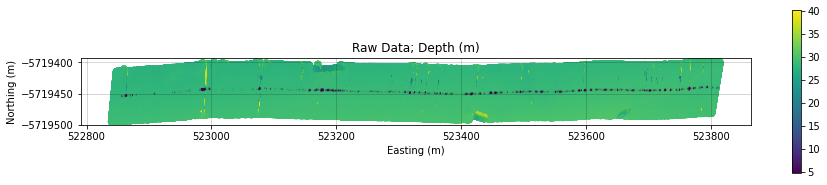

In [6]:
# Using as a model: https://github.com/agile-geoscience/xlines/blob/master/notebooks/11_Gridding_map_data.ipynb
# Recall: Longitude is converted to x coordinate (easting); latitude is converted to y coordinate (northing)

fig1, ax1 = plt.subplots(figsize=(15,15))
im1 = ax1.scatter(data["x"], data["y"], c=data["depth"], vmin=data["depth"].min(), vmax=data["depth"].max())
# set_aspect(1) is synonomous with 'equal'; i.e. same scaling for x and y
ax1.set_aspect(1)
# Disable scientific notation of axes ticks:
ax1.ticklabel_format(useOffset=False, style='plain')
ax1.set_xlabel("Easting (m)")
ax1.set_ylabel("Northing (m)")
ax1.set_title("Raw Data; Depth (m)")
ax1.grid(c='k', alpha=0.2)
cb1 = fig1.colorbar(im1, shrink=0.2)
#plt.show()

------------------------------------------------------------
Plot cleaned data:
------------------------------------------------------------

In [7]:
data_clean = data[data["flag"] != 1]

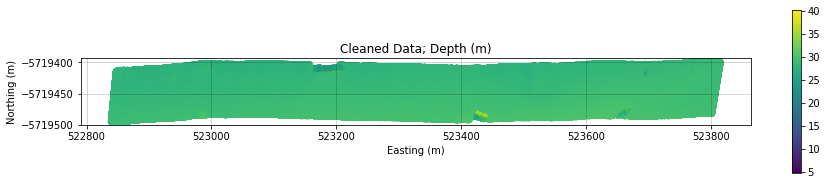

In [8]:
fig2, ax2 = plt.subplots(figsize=(15,15))
im2 = ax2.scatter(data_clean["x"], data_clean["y"], c=data_clean["depth"], vmin=data["depth"].min(), vmax=data["depth"].max())
# set_aspect(1) is synonomous with 'equal'; i.e. same scaling for x and y
ax2.set_aspect(1)
# Disable scientific notation of axes ticks:
ax2.ticklabel_format(useOffset=False, style='plain')
ax2.set_xlabel("Easting (m)")
ax2.set_ylabel("Northing (m)")
ax2.set_title("Cleaned Data; Depth (m)")
ax2.grid(c='k', alpha=0.2)
cb2 = fig2.colorbar(im2, shrink=0.2)
#plt.show()

------------------------------------------------------------
Subsample dataset:
------------------------------------------------------------

In [9]:
subsample = 0.025 # This works, but takes forever in the kriging algorithms...
subsample = 0.001 # One data point for every 1000 data points! Ah!
subsample_size = int(len(data.index) * subsample)

# Subset x, y, z:
x_sub = data["x"].sample(subsample_size)
y_sub = data["y"].sample(subsample_size)
z_sub = data["depth"].sample(subsample_size)

------------------------------------------------------------
Plot sub-sampled, raw data:
------------------------------------------------------------

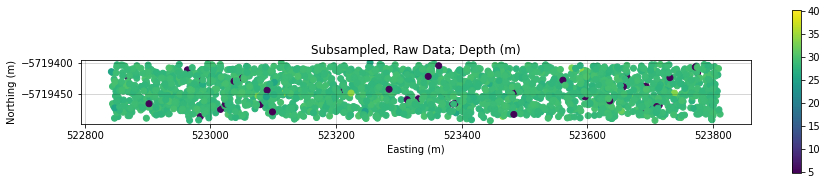

In [10]:
fig3, ax3 = plt.subplots(figsize=(15,15))
im3 = ax3.scatter(x_sub, y_sub, c=z_sub, vmin=data["depth"].min(), vmax=data["depth"].max())
# set_aspect(1) is synonomous with 'equal'; i.e. same scaling for x and y
ax3.set_aspect(1)
# Disable scientific notation of axes ticks:
ax3.ticklabel_format(useOffset=False, style='plain')
ax3.set_xlabel("Easting (m)")
ax3.set_ylabel("Northing (m)")
ax3.set_title("Subsampled, Raw Data; Depth (m)")
ax3.grid(c='k', alpha=0.2)
cb3 = fig3.colorbar(im3, shrink=0.2)
plt.show()

------------------------------------------------------------
Interpolate with radial basis function the subsampled data:
------------------------------------------------------------


In [11]:
# Using as a model: https://github.com/agile-geoscience/xlines/blob/master/notebooks/11_Gridding_map_data.ipynb
# Make a regular grid, which represents points we want to predict:
# (1 indicates a bin every 1 m)
grid_x, grid_y = np.mgrid[(data["x"].min() - 10):(data["x"].max() + 10):1,
                 (data["y"].min() - 10):(data["y"].max() + 10):1]
#plt.figure(figsize=(11,8.5))
#fig = plt.scatter(grid_x, grid_y)

In [12]:
# Make and n-dimensional interpolator:
rbfi = Rbf(x_sub, y_sub, z_sub)
# Predict on the regular grid:
di = rbfi(grid_x, grid_y)
#print(np.linalg.cond(di))

------------------------------------------------------------
Plot interpolated, subsampled data:
------------------------------------------------------------

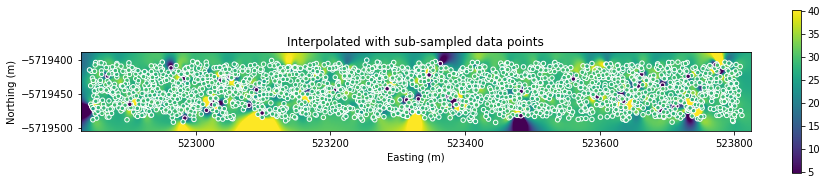

In [13]:
extent = [(data["x"].min() - 10), (data["x"].max() + 10),
          (data["y"].min() - 10), (data["y"].max() + 10)]

fig4, ax4 = plt.subplots(figsize=(15,15))
c1 = plt.imshow(di.T, origin="lower", extent=extent, vmin=data["depth"].min(), vmax=data["depth"].max())
c2 = plt.scatter(x_sub, y_sub, s=20, c=z_sub, edgecolors='white', vmin=data["depth"].min(), vmax=data["depth"].max())
ax4.ticklabel_format(useOffset=False, style='plain')
ax4.set_xlabel("Easting (m)")
ax4.set_ylabel("Northing (m)")
ax4.set_title("Interpolated with sub-sampled data points")
plt.colorbar(c1, shrink=0.2)

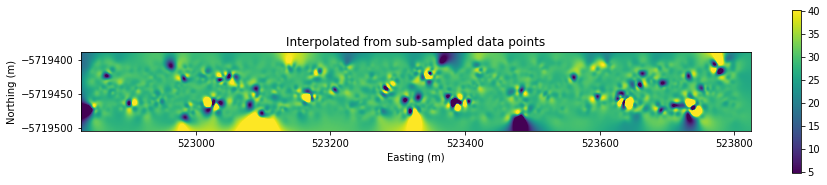

In [14]:
fig5, ax5 = plt.subplots(figsize=(15,15))
c1 = plt.imshow(di.T, origin="lower", extent=extent, vmin=data["depth"].min(), vmax=data["depth"].max())
ax5.ticklabel_format(useOffset=False, style='plain')
ax5.set_xlabel("Easting (m)")
ax5.set_ylabel("Northing (m)")
ax5.set_title("Interpolated from sub-sampled data points")
plt.colorbar(c1, shrink=0.2)

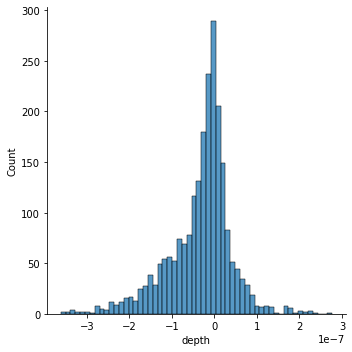

In [75]:
# depth_hat = rbfi(x_sub, y_sub)
# sns.displot(depth_hat - z_sub)

------------------------------------------------------------
Interpolate with varying 'smooth' option:
------------------------------------------------------------

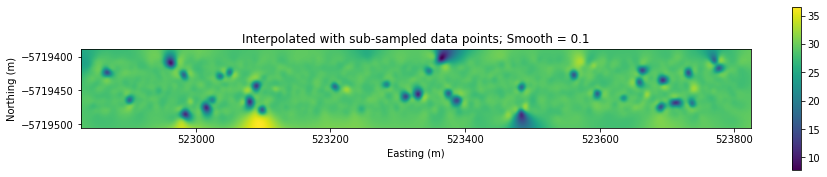

In [15]:
rbfi = Rbf(x_sub, y_sub, z_sub, smooth=0.1)
di = rbfi(grid_x, grid_y)

fig6, ax6 = plt.subplots(figsize=(15,15))
c1 = plt.imshow(di.T, origin="lower", extent=extent)
ax6.ticklabel_format(useOffset=False, style='plain')
ax6.set_xlabel("Easting (m)")
ax6.set_ylabel("Northing (m)")
ax6.set_title("Interpolated with sub-sampled data points; Smooth = 0.1")
plt.colorbar(c1, shrink=0.2)

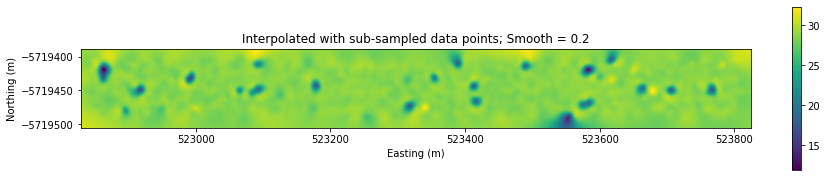

In [69]:
rbfi = Rbf(x_sub, y_sub, z_sub, smooth=0.2)
di = rbfi(grid_x, grid_y)

fig6, ax6 = plt.subplots(figsize=(15,15))
c1 = plt.imshow(di.T, origin="lower", extent=extent)
ax6.ticklabel_format(useOffset=False, style='plain')
ax6.set_xlabel("Easting (m)")
ax6.set_ylabel("Northing (m)")
ax6.set_title("Interpolated with sub-sampled data points; Smooth = 0.2")
plt.colorbar(c1, shrink=0.2)


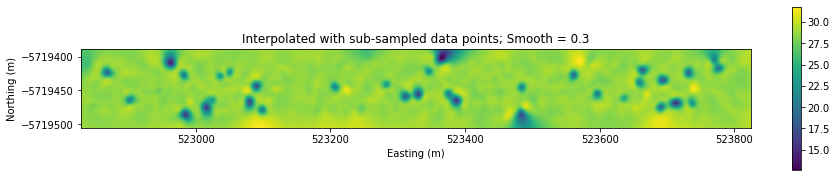

In [17]:
rbfi = Rbf(x_sub, y_sub, z_sub, smooth=0.3)
di = rbfi(grid_x, grid_y)

fig6, ax6 = plt.subplots(figsize=(15,15))
c1 = plt.imshow(di.T, origin="lower", extent=extent)
ax6.ticklabel_format(useOffset=False, style='plain')
ax6.set_xlabel("Easting (m)")
ax6.set_ylabel("Northing (m)")
ax6.set_title("Interpolated with sub-sampled data points; Smooth = 0.3")
plt.colorbar(c1, shrink=0.2)

------------------------------------------------------------
Interpolate with scipy.griddata():
------------------------------------------------------------


In [35]:
# Using as a model: https://github.com/agile-geoscience/xlines/blob/master/notebooks/11_Gridding_map_data.ipynb
points = np.array([x_sub.tolist(), y_sub.tolist()]).T
print(len(points))
print(len(points[0]))
print(len(z_sub))

grid_z_nearest = griddata(points, z_sub, (grid_x, grid_y), method="nearest")
grid_z_linear = griddata(points, z_sub, (grid_x, grid_y), method="linear")
grid_z_cubic = griddata(points, z_sub, (grid_x, grid_y), method="cubic")

2283
2
2283


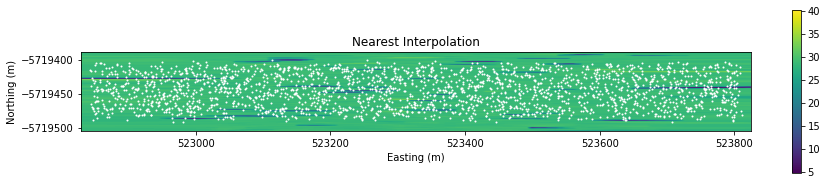

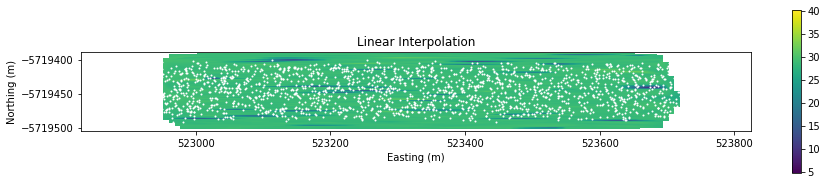

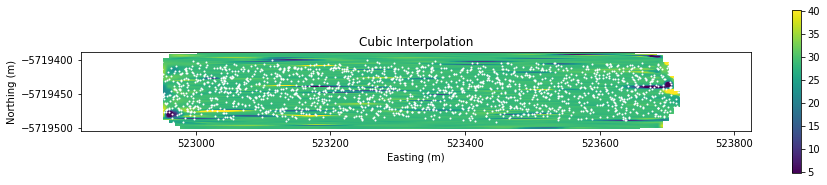

In [44]:
fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(grid_z_nearest, origin="lower", extent=extent, vmin=data["depth"].min(), vmax=data["depth"].max())
ax.scatter(x_sub, y_sub, s=1, c='w')
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.set_title("Nearest Interpolation")
fig.colorbar(im, shrink=0.2)

fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(grid_z_linear, origin="lower", extent=extent, vmin=data["depth"].min(), vmax=data["depth"].max())
ax.scatter(x_sub, y_sub, s=1, c='w')
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.set_title("Linear Interpolation")
fig.colorbar(im, shrink=0.2)

fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(grid_z_cubic, origin="lower", extent=extent, vmin=data["depth"].min(), vmax=data["depth"].max())
ax.ticklabel_format(useOffset=False, style='plain')
ax.scatter(x_sub, y_sub, s=1, c='w')
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.set_title("Cubic Interpolation")
fig.colorbar(im, shrink=0.2)

------------------------------------------------------------
## Preliminary Surface:
(It looks pretty bad! Lots of flyers and deeps on this line.)
------------------------------------------------------------

In [ ]:
fig = plt.figure(figsize=(11, 8.5), dpi=100)
ax = plt.axes(projection="3d")

# plot_surface methodj:
# x_temp, y_temp = np.meshgrid(x_sub, y_sub)
# surf = ax.plot_surface(x_temp, y_temp, z_sub)
# Results in error:
# MemoryError: Unable to allocate 9.48 TiB for an array with shape (1141504, 1141504) and data type float64

surf = ax.plot_trisurf(x_sub, y_sub, z_sub,
                       cmap='winter',
                       linewidth=0.2,
                       antialiased=True,
                       edgecolor='none')

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax.set_title("Subsampled surface plot:")

ax.ticklabel_format(useOffset=False, style='plain')
ax.set_xlabel('latitude')
ax.xaxis.labelpad = 15
#plt.xticks(np.arange(min(x_sub), max(x_sub), 0.0002))
ax.set_ylabel('longitude')
ax.yaxis.labelpad = 15
#plt.yticks(np.arange(min(y_sub), max(y_sub), 0.0002))
ax.set_zlabel('depth')

fig.tight_layout(pad=2)

#plt.show()

## Interpolation Methods:
Good resource on interpolation methods: https://www.gisresources.com/types-interpolation-methods_3/

## Kriging!
Kriging is a geostatistical interpolation technique that considers both the distance and the degree of variation
between known data points when estimating values in unknown areas. A kriged estimate is a weighted linear combination
of the known sample values around the point to be estimated.

Kriging procedure that generates an estimated surface from a scattered set of points with z-values. Kriging assumes
that the distance or direction between sample points reflects a spatial correlation that can be used to explain
variation in the surface. The Kriging tool fits a mathematical function to a specified number of points, or all points
within a specified radius, to determine the output value for each location. Kriging is a multistep process; it includes
exploratory statistical analysis of the data, variogram modeling, creating the surface, and (optionally) exploring a
variance surface. Kriging is most appropriate when you know there is a spatially correlated distance or directional
bias in the data. It is often used in soil science and geology.

In [ ]:
# ordinary_kriging = OrdinaryKriging(x_sub, y_sub, z_sub, variogram_model="linear", verbose=False, enable_plotting=False)
# ordinary_kriging.display_variogram_model()
#

In [ ]:
# xpoints = np.arange(min(lat), max(lat), (max(lat) - min(lat)) * 0.01)
# ypoints = np.arange(min(lon), max(lon), (max(lon) - min(lon)) * 0.01)
# print(len(xpoints))
# print(len(ypoints))
# z, ss = ordinary_kriging.execute(style="grid", xpoints=xpoints, ypoints=ypoints)
# #z, ss = ordinary_kriging.execute("grid",)
# plt.imshow(z)
# fmt = '%1.20f'
# plt.colorbar(format=fmt)
# #plt.show()
#
# #ordinary_kriging = OrdinaryKriging(x, y, z, variogram_model="gaussian")
# #ordinary_kriging.display_variogram_model()